# Recurent Neural Network (RNN)

RNNs are a type of neural network that can be used to model sequence data. RNNs, which are formed from feedforward networks, are similar to human brains in their behaviour. Simply said, recurrent neural networks can anticipate sequential data in a way that other algorithms can’t.

![image](https://editor.analyticsvidhya.com/uploads/33870quora.png)

All of the inputs and outputs in standard neural networks are independent of one another, however in some circumstances, such as when predicting the next word of a phrase, the prior words are necessary, and so the previous words must be remembered. As a result, RNN was created, which used a Hidden Layer to overcome the problem. The most important component of RNN is the Hidden state, which remembers specific information about a sequence.

RNNs have a Memory that stores all information about the calculations. It employs the same settings for each input since it produces the same outcome by performing the same task on all inputs or hidden layers.

## Load Libraries and Dataset

In [24]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
import re

from collections import defaultdict
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping


In [25]:
# Load dataset from database

db = sqlite3.connect('C:/Users/HP/BInar/WAN PLATINUM/database.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
data = pd.read_sql_query(q_data, db)
data.head(10)

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative
5,makanan beragam harga makanan di food stall ak...,positive
6,pakai kartu kredit baca tidak untung malah rug...,negative
7,tempat unik bagus buat foto makanan enak pegaw...,positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [26]:
# Data distribution check

data['Label'].value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

## Feature-Label Classification

In [27]:
# Group data tweet

positive_tweet = data.loc[data['Label']=='positive'].Tweet.tolist()
negative_tweet = data.loc[data['Label']=='negative'].Tweet.tolist()
neutral_tweet = data.loc[data['Label']=='neutral'].Tweet.tolist()

# Group data label

positive_label = data.loc[data['Label']=='positive'].Label.tolist()
negative_label = data.loc[data['Label']=='negative'].Label.tolist()
neutral_label = data.loc[data['Label']=='neutral'].Label.tolist()

In [28]:
# Final sentiment data check

total_data = positive_tweet + negative_tweet + neutral_tweet
labels = positive_label + neutral_label + negative_label

print("Positive: %s, Negative: %s, Neutral: %s" % (len(positive_tweet), len(negative_tweet), len(neutral_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Negative: 3412, Neutral: 1138
Total data: 10933
Total labels: 10933


## Feature Extraction

In [29]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("tokenizer.pickle has been created!")

X = tokenizer.texts_to_sequences(total_data)
vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)

with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("x_pad_sequences.pickle has been created!")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("tokenizer.pickle has been created!")


tokenizer.pickle has been created!
x_pad_sequences.pickle has been created!
tokenizer.pickle has been created!


In [30]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Train-Test Data Split

In [31]:
with open("x_pad_sequences.pickle", 'rb') as file:
    X = pickle.load(file)

with open("y_labels.pickle", 'rb') as file:
    Y = pickle.load(file)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Model Training

We will now train the RNN algorithm and perform 5-fold cross-validation to assess the stability of its performance.

In [32]:
# Model Training Cross Validation

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100 

units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    # Create model architecture

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.8 ))
    model.add(Dense(3,activation='softmax'))

    # model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.00005 )
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training -", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,4))


Epoch 1/50
274/274 [==============================] - 16s 54ms/step - loss: 0.9323 - accuracy: 0.5749 - val_loss: 0.7726 - val_accuracy: 0.7243
Epoch 2/50
274/274 [==============================] - 15s 55ms/step - loss: 0.7554 - accuracy: 0.7151 - val_loss: 0.7256 - val_accuracy: 0.7380
Epoch 3/50
274/274 [==============================] - 14s 50ms/step - loss: 0.7090 - accuracy: 0.7375 - val_loss: 0.6749 - val_accuracy: 0.7558
Epoch 4/50
274/274 [==============================] - 13s 48ms/step - loss: 0.6467 - accuracy: 0.7631 - val_loss: 0.6187 - val_accuracy: 0.7673
Epoch 5/50
274/274 [==============================] - 14s 52ms/step - loss: 0.5986 - accuracy: 0.7741 - val_loss: 0.5901 - val_accuracy: 0.7764
Epoch 6/50
274/274 [==============================] - 14s 52ms/step - loss: 0.5679 - accuracy: 0.7825 - val_loss: 0.5787 - val_accuracy: 0.7705
Epoch 7/50
274/274 [==============================] - 14s 51ms/step - loss: 0.5497 - accuracy: 0.7903 - val_loss: 0.5602 - val_accuracy:

c:\Users\HP\anaconda3\envs\envawan-8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\envs\envawan-8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\envs\envawan-8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


274/274 [==============================] - 13s 45ms/step - loss: 0.8904 - accuracy: 0.6024 - val_loss: 0.7663 - val_accuracy: 0.7151
Epoch 2/50
274/274 [==============================] - 12s 44ms/step - loss: 0.7473 - accuracy: 0.7176 - val_loss: 0.7189 - val_accuracy: 0.7407
Epoch 3/50
274/274 [==============================] - 12s 44ms/step - loss: 0.6974 - accuracy: 0.7434 - val_loss: 0.6656 - val_accuracy: 0.7558
Epoch 4/50
274/274 [==============================] - 12s 44ms/step - loss: 0.6430 - accuracy: 0.7609 - val_loss: 0.6149 - val_accuracy: 0.7705
Epoch 5/50
274/274 [==============================] - 13s 47ms/step - loss: 0.5965 - accuracy: 0.7756 - val_loss: 0.5885 - val_accuracy: 0.7764
Epoch 6/50
274/274 [==============================] - 12s 44ms/step - loss: 0.5631 - accuracy: 0.7866 - val_loss: 0.5738 - val_accuracy: 0.7773
Epoch 7/50
274/274 [==============================] - 12s 45ms/step - loss: 0.5426 - accuracy: 0.7924 - val_loss: 0.5612 - val_accuracy: 0.7787
Epo

c:\Users\HP\anaconda3\envs\envawan-8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\envs\envawan-8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\anaconda3\envs\envawan-8\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


274/274 [==============================] - 13s 45ms/step - loss: 0.9110 - accuracy: 0.5748 - val_loss: 0.7620 - val_accuracy: 0.6978
Epoch 2/50
274/274 [==============================] - 12s 44ms/step - loss: 0.7402 - accuracy: 0.7129 - val_loss: 0.6923 - val_accuracy: 0.7485
Epoch 3/50
274/274 [==============================] - 12s 44ms/step - loss: 0.6854 - accuracy: 0.7386 - val_loss: 0.6724 - val_accuracy: 0.7403
Epoch 4/50
274/274 [==============================] - 12s 44ms/step - loss: 0.6396 - accuracy: 0.7595 - val_loss: 0.6221 - val_accuracy: 0.7732
Epoch 5/50
274/274 [==============================] - 12s 44ms/step - loss: 0.6038 - accuracy: 0.7718 - val_loss: 0.6052 - val_accuracy: 0.7755
Epoch 6/50
274/274 [==============================] - 12s 44ms/step - loss: 0.5787 - accuracy: 0.7805 - val_loss: 0.5923 - val_accuracy: 0.7769
Epoch 7/50
274/274 [==============================] - 12s 43ms/step - loss: 0.5498 - accuracy: 0.7846 - val_loss: 0.5779 - val_accuracy: 0.7764
Epo

## Evaluation

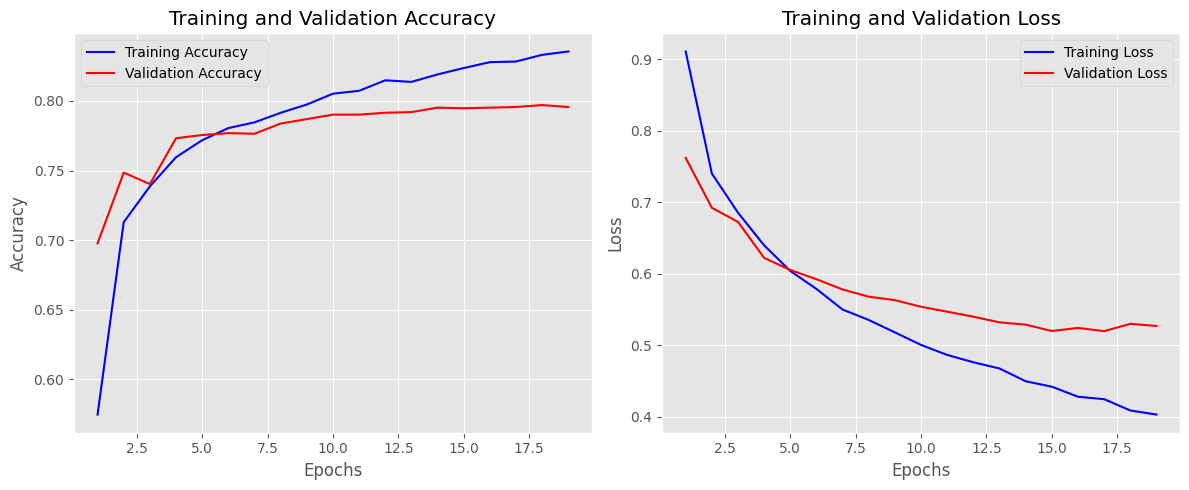

In [33]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

%matplotlib inline
plot_history(history)


- The model achieved a stable accuracy of 79.84% with 5-fold cross validation.
- The first epoch showed the best performance with minimal loss.
- In most cases, the model training stopped after the seventeen epoch.

In [34]:
# Save the model

model.save('model.h5')
print("Model has created!")

Model has created!


In [35]:
input_text = """
Makanannya enak  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 131ms/step
Text:  makanannya enak  
Sentiment: positive


In [36]:
input_text = """
Biasa aja musiknya  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 143ms/step
Text:  biasa aja musiknya  
Sentiment: negative


In [37]:
input_text = """
Payah kamu  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 154ms/step
Text:  payah kamu  
Sentiment: negative
